# From raw neutron counts to volumetric soil moisture

**For the time being, this notebook is a sandbox.** Step by step, we will migrate mature functions to the actual `cosmicsense` library.

In [41]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [42]:
import cosmicsense as cs

In [43]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

## Read raw data

#### CRNS records

`crns_sample1.txt` containts raw CRNS neutron counts for a standard and a bare counter, as well as air pressure and temperature time series.

In [44]:
# Sensor counts
crns = pd.read_csv("../../../data/crns_sample1.txt", sep="\t")
crns.columns = ["recnum", "datetime", "press", "temp", "relhum", "volt", 
                "n1c", "n2c", "n1et", "n2et", "fileno", "id_flag"]
crns.datetime = pd.to_datetime(crns.datetime)
crns = crns.set_index("datetime")
crns.head()

,recnum,press,temp,relhum,volt,n1c,n2c,n1et,n2et,fileno,id_flag
datetime,,,,,,,,,,,
2010-09-17 12:22:42,1,1011.4,23.6,49.4,12.353,5,0,10,0,16,5
2010-09-17 12:23:00,2,1011.4,23.2,49.9,12.353,5,0,17,0,16,5
2010-09-17 12:24:00,3,1011.4,23.0,50.7,12.353,12,0,60,0,16,5
2010-09-17 12:25:00,4,1011.3,23.0,50.7,12.352,7,0,60,0,16,5
2010-09-17 12:26:00,5,1011.3,23.1,50.6,12.353,10,0,60,0,16,5


#### NMBD station data

`nmdb_corr.txt` contains reference (background) neutron counts from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL`, `KIEL2`, and `DRBS` (Dourbes, Belgium), from Jan 2010 to Feb 2019. 

In [45]:
# NMDB data
nmdb = pd.read_csv("../../../data/nmdb_corr.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")
nmdb.head()

,JUNG,JUNG1,DRBS,KIEL,KIEL2
datetime,,,,,
2010-01-01 00:00:00,168.839,396.262,115.620,182.344,NaN
2010-01-01 06:00:00,170.389,398.503,NaN,183.750,NaN
2010-01-01 12:00:00,169.094,394.820,NaN,182.454,NaN
2010-01-01 18:00:00,167.714,390.362,NaN,181.456,NaN
2010-01-02 00:00:00,167.750,391.708,115.643,180.778,NaN


## Quick view of the raw data

(734032.5157638888, 734441.9979166667)

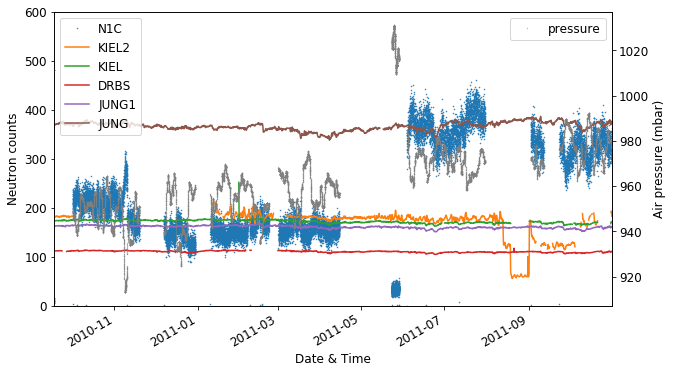

In [46]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(10,6))

crns.n1c.plot(ax=ax, label="N1C", linestyle="None", marker=".", ms=1)
nmdb.KIEL2.plot(ax=ax, label="KIEL2")
nmdb.KIEL.plot(ax=ax, label="KIEL")
nmdb.DRBS.plot(ax=ax, label="DRBS")
nmdb.JUNG.plot(ax=ax, label="JUNG1")
nmdb.JUNG1.plot(ax=ax, label="JUNG")
ax.legend(loc="upper left")
plt.xlabel("Date & Time")
plt.ylabel("Neutron counts")
plt.ylim(0,600)
#plt.grid()

ax2 = ax.twinx()
presspl = crns.press.plot(ax=ax2, label="pressure", color="grey", linestyle="None", marker=".", ms=0.5)
plt.ylabel("Air pressure (mbar)")
plt.legend(loc="upper right")

#set ticks every month
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#plt.tick_params(axis='both', which='major')

plt.xlim(crns.index[0], crns.index[-1])

#plt.rcdefaults()

## Aggregating to a common time interval, handling gaps

Resampling or aggregation (to a commmon, typically lower temporal resolution) can be somewhat arbitrary. The sampling interval in the time series changes and there are gaps, too. E.g., under which conditions do we consider to have "enough samples" of counts of 10 minute intervals in order to compute the cumulative neutron count within 6 hours? A complete coverage would provide 36 10-minute samples. But maybe we are happy with 30 samples? Yet, what happens if the sample time interval changes to 20 minutes? Then, 18 samples would correspond to a complete coverage of a 6 hour interval. 

A less arbitrary approach would be to compute the average neutron count rate per second for any sample interval, then average that rate over the target interval, and finally integrate that average count rate. For that purpose, we have to extract the sample time interval from the time series. Still, that is subject to some degree of arbitraryness: For any time step, is a long temporal distance to the preceeding time step a change in sampling interval, or just a gap?

First, we try to identify which intervals are "intentional" and which are artefacts of sampling gaps.

In [47]:
crns["numsecs"] = np.nan
crns.loc[1:, "numsecs"] = (crns.index[1:] - crns.index[0:-1]).total_seconds().astype("int")

Text(0, 0.5, 'Raw neutron counts')

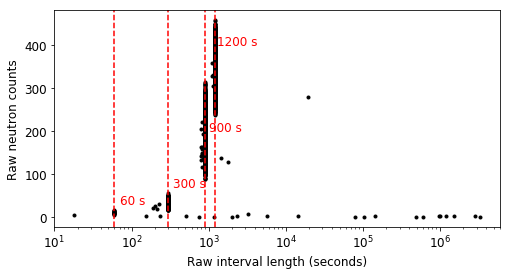

In [48]:
#plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(8, 4))
plt.semilogx(crns.numsecs, crns.n1c, "k.")
plt.axvline(x=1200, color="red", ls="dashed")
plt.text(1300, 400, "1200 s", color="red")
plt.axvline(x=900, color="red", ls="dashed")
plt.text(1000, 200, "900 s", color="red")
plt.axvline(x=300, color="red", ls="dashed")
plt.text(350, 70, "300 s", color="red")
plt.axvline(x=60, color="red", ls="dashed")
plt.text(70, 30, "60 s", color="red")
plt.xlabel("Raw interval length (seconds)")
plt.ylabel("Raw neutron counts")
#plt.rcdefaults()

It apears that 60, 300, 900 and 1200 seconds are intentional. Any other inerval will be considered an artefact and should be filtered. 

In [49]:
crns["numsecs_filt"] = crns["numsecs"]
crns.loc[~np.in1d(crns.numsecs, [60, 300, 900, 1200]), "numsecs_filt"] = np.nan

(0, 3600)

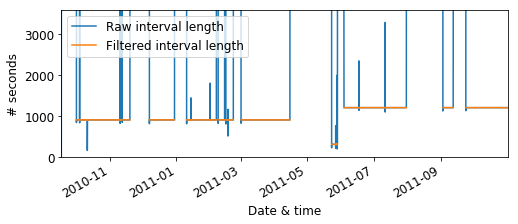

In [50]:
#plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(figsize=(8,3))
crns.numsecs.plot(label="Raw interval length")
crns.numsecs_filt.plot(label="Filtered interval length")
plt.legend()
plt.xlabel("Date & time")
plt.ylabel("# seconds")
plt.ylim(0, 1*3600)
#plt.rcdefaults()

Now we compute the neutron count rates per hour (cph), and compute the average count rate over six hour intervals, filtering those intervals which do not have a temporal coverage of 100 percent.

In [51]:
# Count rate is computed in "counts per hour" (cph)
crns["n1crate"] = crns.n1c / (cs.conv.s_to_h( crns.numsecs_filt ))

In [52]:
interval = cs.conv.h_to_s(6)
# Percent temporal coverage (sample seconds per target interval)
crns_6h = pd.DataFrame( {"coverage": crns.numsecs_filt.resample("6H").sum() * 100 / interval})
# Average count rate (in cph) per target interval
crns_6h["n1crate"] = crns.n1crate.resample("6H").mean()
# Set those intervals to NaN which do not have full coverage
crns_6h.loc[crns_6h.coverage < 100, "n1crate"] = np.nan

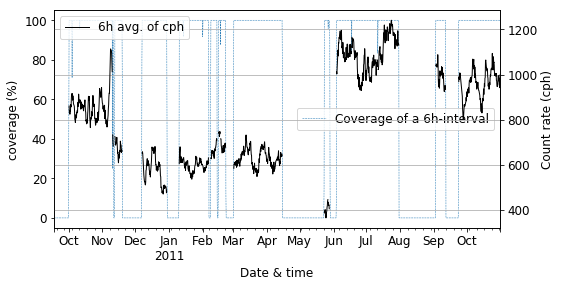

In [53]:
fig, ax = plt.subplots(figsize=(8,4))
crns_6h.coverage.plot(label="Coverage of a 6h-interval", ls="dashed", lw=0.5)
plt.ylabel("coverage (%)")
plt.xlabel("Date & time")
plt.legend()
ax2 = ax.twinx()
crns_6h.n1crate.plot(ax=ax2, label="6h avg. of cph", lw=1, color="black")
plt.legend()
plt.ylabel("Count rate (cph)")
plt.grid()

## Correcting for variations in incoming neutron flux

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch.

**Question: How to objectively quantify $f_{ref}$ from NMDB time series?**

The following figure shows the time series of our CRNS counts and the NMDB data.

(356868, 366690)

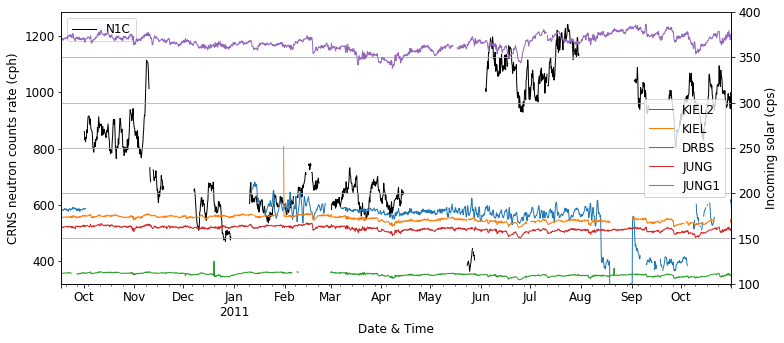

In [54]:
plt.rc('font', **{'size'   : 12})

fig, ax = plt.subplots(figsize=(12,5))

crns_6h.n1crate.plot(ax=ax, label="N1C", color="black", lw=1)
plt.xlabel("Date & Time")
plt.ylabel("CRNS neutron counts rate (cph)")
plt.legend(loc="upper left")

ax2 = ax.twinx()
nmdb.KIEL2.plot(ax=ax2, label="KIEL2", lw=1)
nmdb.KIEL.plot(ax=ax2, label="KIEL", lw=1)
nmdb.DRBS.plot(ax=ax2, label="DRBS", lw=1)
nmdb.JUNG.plot(ax=ax2, label="JUNG", lw=1)
nmdb.JUNG1.plot(ax=ax2, label="JUNG1", lw=1)
plt.ylim(100,400)
plt.legend()
plt.ylabel("Incoming solar (cps)")
plt.grid()

plt.xlim(crns_6h.index[0], crns_6h.index[-1])

We use $f_{ref} = 150 cps$ for station `JUNG`, as sugggested by Schroen (2016).

In [55]:
nmdb["fi"] = nmdb.JUNG / 150.
# The following is just to reduce the series of correction factors to the extent of the CRNS series,
#   but in a new DataFrame object corrfacts
crns_6h = pd.merge(crns_6h, nmdb.fi, how='left', left_index=True, right_index=True)
crns_6h.head()

,coverage,n1crate,fi
datetime,,,
2010-09-17 12:00:00,4.166667,NaN,1.079540
2010-09-17 18:00:00,0.000000,NaN,1.079427
2010-09-18 00:00:00,0.000000,NaN,1.082600
2010-09-18 06:00:00,0.000000,NaN,1.084860
2010-09-18 12:00:00,0.000000,NaN,1.081220


## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

**Question: How do we quantify $p_0$? Based on site average, or just based on standard sea level pressure (1013 mbar)?**

For now, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [56]:
p_0 = cs.conv.strd_baro_pressure
L = 131.6 # g/cm2
crns["fp"] = cs.core.corrfact_baro(crns.press, p_0, L)

In [57]:
# Compute 6h average correction factor and merge
fp = crns.fp.resample("6H").mean()
crns_6h = pd.merge(crns_6h, fp, how='left', left_index=True, right_index=True)
crns_6h.head()

,coverage,n1crate,fi,fp
datetime,,,,
2010-09-17 12:00:00,4.166667,NaN,1.079540,1.015549
2010-09-17 18:00:00,0.000000,NaN,1.079427,NaN
2010-09-18 00:00:00,0.000000,NaN,1.082600,NaN
2010-09-18 06:00:00,0.000000,NaN,1.084860,NaN
2010-09-18 12:00:00,0.000000,NaN,1.081220,NaN


## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

We now apply these functions to the original CRNS time series, then we resample $f_wv$ to 6 hour intervals.

In [58]:
# Compute correction factor from original resolution
h = cs.conv.absolute_humidity(crns.temp, crns.relhum)
crns["fwv"] = cs.core.corrfact_vapor_rosolem(h)

In [59]:
# Compute 6h average correction factor and merge
fwv = crns.fwv.resample("6H").mean()
crns_6h = pd.merge(crns_6h, fwv, how='left', left_index=True, right_index=True)
crns_6h.head()

,coverage,n1crate,fi,fp,fwv
datetime,,,,,
2010-09-17 12:00:00,4.166667,NaN,1.079540,1.015549,1.034861
2010-09-17 18:00:00,0.000000,NaN,1.079427,NaN,NaN
2010-09-18 00:00:00,0.000000,NaN,1.082600,NaN,NaN
2010-09-18 06:00:00,0.000000,NaN,1.084860,NaN,NaN
2010-09-18 12:00:00,0.000000,NaN,1.081220,NaN,NaN


## Summing up correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

**Attention**: The above formula from Andreasen et al. (2018) might be incorrect. Depending on how $f_p$ is computed (with $p_0 - p$ or $p - p_0$), $f_p$ needs to go to the numerator. E.g. Schroen et al. (2015) compute $f_i$ differently...**need to check this.** 

In [60]:
crns_6h["n1cratecorr"] = crns_6h.n1crate * crns_6h.fwv * crns_6h.fp / crns_6h.fi

(356868, 366690)

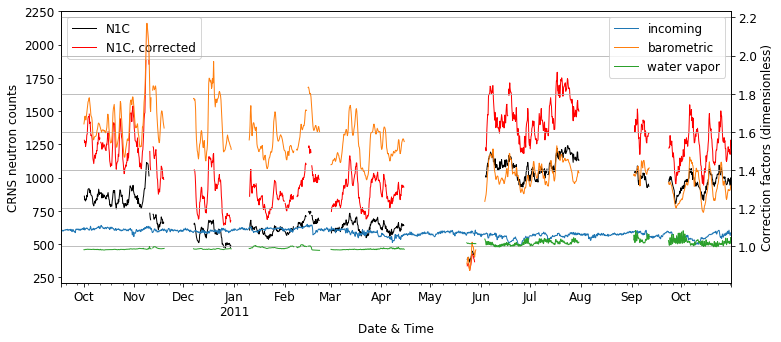

In [61]:
plt.rc('font', **{'size'   : 12})

fig, ax = plt.subplots(figsize=(12,5))

crns_6h.n1crate.plot(ax=ax, label="N1C", color="black", lw=1)
crns_6h.n1cratecorr.plot(ax=ax, label="N1C, corrected", color="red", lw=1)
plt.xlabel("Date & Time")
plt.ylabel("CRNS neutron counts")
plt.legend(loc="upper left")

ax2 = ax.twinx()
crns_6h.fi.plot(ax=ax2, label="incoming", lw=1)
crns_6h.fp.plot(ax=ax2, label="barometric", lw=1)
crns_6h.fwv.plot(ax=ax2, label="water vapor", lw=1)
#plt.ylim(100,400)
plt.legend()
plt.ylabel("Correction factors (dimensionless)")
plt.grid()

plt.xlim(crns_6h.index[0], crns_6h.index[-1])

## From corrected neutron counts to soil moisture estimation

Volumetric soil moisture is estimated from a single relation that includes a local calibration parameter $N_0$. [Desilets et al. (2010)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009WR008726) suggested the following one:

\begin{equation*}
\theta = \Bigl(\frac{a_0}{\frac{N_{corr}}{N_0} - a_1} - a_2\Bigl) * \frac{\rho_b}{\rho_w}
\end{equation*}

While $a_0$, $a_1$ and $a_2$ are empirical parameters, soil bulk density $\rho_b$ can be measured or retrieved via transfer functions or literature, the density of water $\rho_w$ is a function of temperature and salinity, although the approximate value of 1000 kg/m3 is can be used without introducing much error as compared to other uncertainties.

The parameter $N_0$ depends on the local hydrogen pool and footprint, and needs to be obtained from calibration with gravimetric soil moisture measurements in the footprint at a defined point in time. For the time being, we just take a wild guess and set $N_0$ to 1300 cph.

In [62]:
crns_6h["theta"] = cs.core.n_to_theta_desilets(crns_6h.n1cratecorr, n0=1290.)

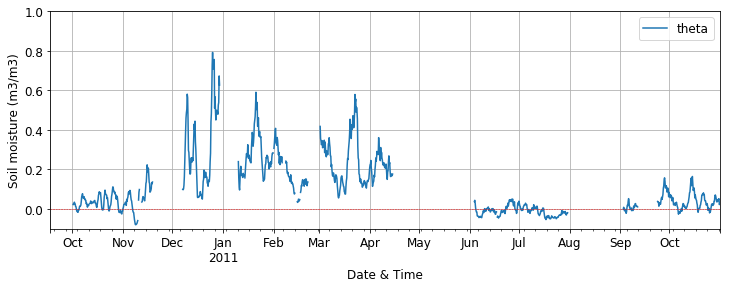

In [63]:
fig, ax = plt.subplots(figsize=(12,4))
crns_6h.theta.plot(ylim=(-0.1,1))
plt.axhline(y=0, color="red", ls="--", lw=0.5)
plt.xlabel("Date & Time")
plt.ylabel("Soil moisture (m3/m3)")
plt.legend()
plt.grid()

Something's obviously not right,  yet. Negative theta and exceptionally high values of theta above that exceed the pore volume.

## Local calibration of $N_0$

In [64]:
samples = pd.read_csv("../../../data/crns_sample1_soil.txt", sep=";")
samples.head()

,Unnamed: 0,date,location,depth,wet_cyl_field_g,wet_cyl_lab_g,dry_cyl_lab_g,cyl_g
0,0,5/8/2013,Center,0-5cm,223.0,131.08,105.72,NaN
1,1,5/8/2013,Center,5-10cm,219.0,222.82,198.96,95.94
2,2,5/8/2013,Center,10-15cm,262.0,265.99,238.09,96.01
3,3,5/8/2013,Center,15-20cm,265.0,268.80,238.22,96.00
4,4,5/8/2013,Center,20-25cm,253.0,257.16,235.74,96.08


In [65]:
vol_cyl = 98 # cm3
samples["theta"] = (samples.wet_cyl_lab_g - samples.dry_cyl_lab_g) / 98.
samples["rho_b"] = (samples.dry_cyl_lab_g - samples.cyl_g) / 98.
samples.depth = [depth.strip() for depth in samples.depth]

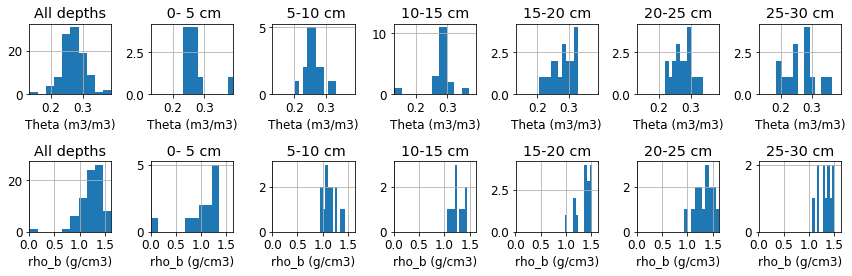

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(12,4), clear=True)
ax = ax.ravel()

samples.theta.hist(ax=ax[0])
ax[0].set_title("All depths")
samples.loc[samples.depth=="0-5cm",   "theta"].hist(ax=ax[1])
ax[1].set_title(" 0- 5 cm")
samples.loc[samples.depth=="5-10cm",  "theta"].hist(ax=ax[2])
ax[2].set_title(" 5-10 cm")
samples.loc[samples.depth=="10-15cm", "theta"].hist(ax=ax[3])
ax[3].set_title("10-15 cm")
samples.loc[samples.depth=="15-20cm", "theta"].hist(ax=ax[4])
ax[4].set_title("15-20 cm")
samples.loc[samples.depth=="20-25cm", "theta"].hist(ax=ax[5])
ax[5].set_title("20-25 cm")
samples.loc[samples.depth=="25-30cm", "theta"].hist(ax=ax[6])
ax[6].set_title("25-30 cm")

samples.rho_b.hist(ax=ax[7])
ax[7].set_title("All depths")
samples.loc[samples.depth=="0-5cm",   "rho_b"].hist(ax=ax[8])
ax[8].set_title(" 0- 5 cm")
samples.loc[samples.depth=="5-10cm",  "rho_b"].hist(ax=ax[9])
ax[9].set_title(" 5-10 cm")
samples.loc[samples.depth=="10-15cm", "rho_b"].hist(ax=ax[10])
ax[10].set_title("10-15 cm")
samples.loc[samples.depth=="15-20cm", "rho_b"].hist(ax=ax[11])
ax[11].set_title("15-20 cm")
samples.loc[samples.depth=="20-25cm", "rho_b"].hist(ax=ax[12])
ax[12].set_title("20-25 cm")
samples.loc[samples.depth=="25-30cm", "rho_b"].hist(ax=ax[13])
ax[13].set_title("25-30 cm")


for i, axi in enumerate(ax):
    if i < 7:
        axi.set_xlim(samples.theta.min(), samples.theta.max())
        axi.set_xlabel("Theta (m3/m3)")
    else:
        axi.set_xlim(samples.rho_b.min(), samples.rho_b.max())
        axi.set_xlabel("rho_b (g/cm3)")

plt.tight_layout()